In [563]:
import matplotlib.pyplot as plt
import importlib
import bitmap_editor
importlib.reload(bitmap_editor)
import numpy as np

height = 6
width = 6
bitmap_matrix = np.zeros(shape=(height,width))
bitmapEditor = bitmap_editor.BitmapEditor(bitmap_matrix)

Canvas(height=60, width=60)

[1 1]
[0 1]
[-1  1]
[ 1 -1]
[-1  0]
[ 1 -1]
[-1 -1]
(1, 1)
(1, 2)
(1, 3)
(1, 1)
(1, 3)
(2, 1)
(2, 3)
(2, 1)
(3, 2)
(3, 3)
(3, 2)
(3, 3)
28


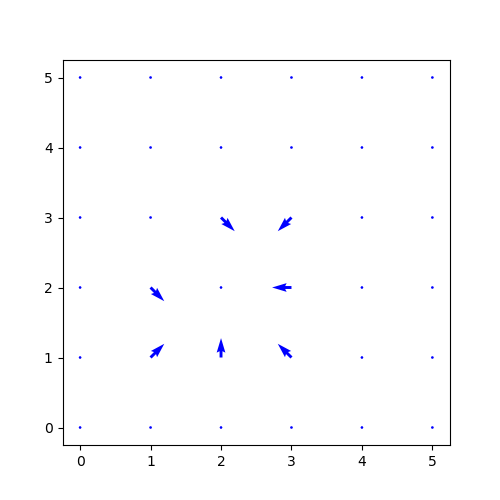

In [564]:
import navier_stokes
importlib.reload(navier_stokes)

grid = np.flip(np.copy(bitmap_matrix), 0)

######### Actual simulation code

fluid_cells = navier_stokes.fluid_cells(grid)
fluid_cell_index = navier_stokes.fluid_cell_index(fluid_cells, grid.shape)

A, b = navier_stokes.projection_A(fluid_cells, fluid_cell_index, grid.shape)

print(len(b))

################
X, Y = np.meshgrid(np.arange(width), np.arange(height))
NormalsU = np.zeros(shape=(height, width))
NormalsV = np.zeros(shape=(height, width))

for fluid_cell in fluid_cells:
    normal = np.array([0, 0])
    if fluid_cell.boundary_normal is not None:
        normal = fluid_cell.boundary_normal
    NormalsU[fluid_cell.grid_index] = normal[0]
    NormalsV[fluid_cell.grid_index] = normal[1]


%matplotlib widget
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, NormalsU, NormalsV, color="b", scale=20)
plt.show()

In [567]:

with np.printoptions(threshold=np.inf):
    print(A)

print(b)
print(len(b))
print(A.shape)

[[-4.   1.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 1.  -3.5  1.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0. ]
 [ 0.   1.  -3.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0. ]
 [ 0.   0.   1.  -3.5  1.   0.   0.   0.5  0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0. ]
 [ 0.   0.   0.   1.  -4.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0. ]
 [ 1.   0.   0.   0.   1.  -4.   0.   0.   1.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1. ]
 [ 1.   0.5  0.   0.   0.   0.  -3.5  0.   1.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

11
0.08516803952295769
[ 1.44290662  1.60188685  1.0368644   0.35656912  0.39841839  0.89601425
  1.97916596 -0.2428535   0.85320894  2.13893471 -0.55870764  0.80080231
  1.72265846  2.56540515 -0.22676003  0.78911647  1.40542234  1.73350029
  1.53877919  0.51180164  0.43528155  0.87986265  1.2945594   1.44141588
  1.1616311   0.65018891  0.59356883  0.91006788]
1.0039182182974995


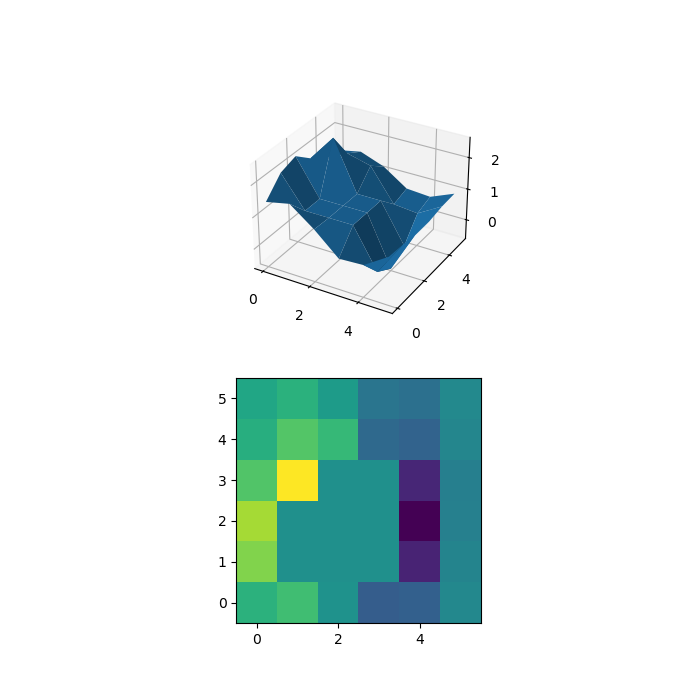

In [565]:
%matplotlib widget
import pyamg

ml = pyamg.ruge_stuben_solver(A)  # Build the multigrid hierarchy
residuals = []
x = ml.solve(b, tol=1e-8, maxiter=10, residuals=residuals)
print(len(residuals))
print(residuals[-1])
# x = np.linalg.solve(A,b)

print(x)

mesh = np.zeros(shape=(height,width))

avg = np.average(x)
print(avg)

for j in range(0,height):
    for i in range(0,width):
        fluid_cell = fluid_cell_index[j][i]
        if fluid_cell is None:
            mesh[j][i] = avg
            continue
        if fluid_cell.boundary_normal is not None:
            # TODO: Calculate the ghost cell value.
            mesh[j][i] = avg
            continue

        # if grid[j][i]:
        # index = fluid_cell_index[j][i]
        mesh[j][i] = x[fluid_cell.non_boundary_index]


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(211, projection='3d')
ax2 = fig.add_subplot(212)
ax2.imshow(mesh, interpolation='none', origin='lower')

# plt.imshow(mesh, interpolation='none', origin='lower')
ax.plot_surface(X,Y,mesh) 
plt.show()

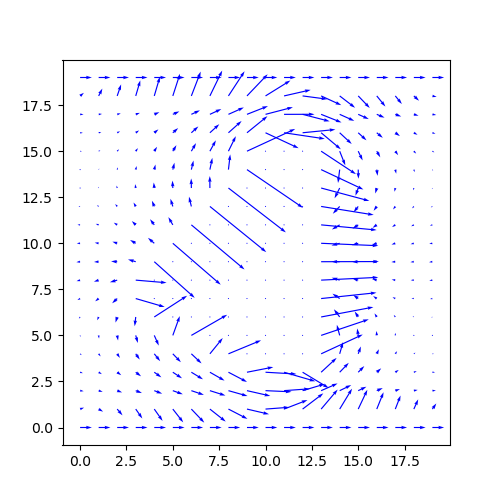

In [531]:
U = np.zeros(shape=mesh.shape)
V = np.zeros(shape=mesh.shape)

for fluid_cell in fluid_cells:
    if fluid_cell.boundary_normal is not None:
        continue

    j,i = fluid_cell.grid_index
    # xa = fluid_cells[fluid_cell.x_diff[0]].grid_index
    # xb = fluid_cells[fluid_cell.x_diff[1]].grid_index
    # xd = fluid_cell.x_diff[2]

    U[j][i] = (mesh[j][(i+1)%width] - mesh[j][(i-1)%width])/2
    V[j][i] = (mesh[j+1][i] - mesh[j-1][i])/2

newU = 1-U

for j,i in np.ndindex(mesh.shape):
    if grid[j][i]:
        newU[j][i]=0

fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, newU, -V, color="b")
# ax.quiver(X, Y, -U, -V, color="b")
# ax.quiver(X, Y, U,V, color="r")
plt.show()

# ax3.quiver(X,Y, 2-U, -V)

In [ ]:
A = np.array([[0,0,1], [0,0,0], [0,0,0]])

print(np.array((1,1)))
# print(len(A))
# obstacle_indices = (np.array(np.where(A == 1)).T - np.array([1,1])).tolist()

obstacle_indices = [(j-1,i-1) for j in range(3) for i in range(3) if A[j][i]]

# print(obstacle_indices)
# print(obstacle_indices)
# print([-1, 1] in obstacle_indices)

# print(np.array([1,1]) == np.abs(np.array([-1,1])))

# corner = np.abs(obstacle_indices[0]) == np.array([1,1])
# print(corner)
# print(np.abs(obstacle_indices[0]) == 
# if ():
#     print('corner')
# np.any([A[i]>8 for i in [(1,1),(2,2),(0,0)]])

In [264]:
np.sign(0)

0